In [26]:
!pip install pretrainedmodels

You should consider upgrading via the 'c:\users\ye8i\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [27]:
import tarfile

In [28]:
cd "C:\Users\Ye8i\OneDrive\Desktop\New folder\101_ObjectCategories-20220917T235144Z-001\"

C:\Users\Ye8i\OneDrive\Desktop\New folder\101_ObjectCategories-20220917T235144Z-001


In [29]:
ls

 Volume in drive C is OS
 Volume Serial Number is 96FC-A07C

 Directory of C:\Users\Ye8i\OneDrive\Desktop\New folder\101_ObjectCategories-20220917T235144Z-001

17-09-2022  23:55    <DIR>          .
17-09-2022  23:55    <DIR>          ..
17-09-2022  23:55    <DIR>          101_ObjectCategories
               0 File(s)              0 bytes
               3 Dir(s)  329,191,002,112 bytes free


In [30]:
!pip install imutils

You should consider upgrading via the 'c:\users\ye8i\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [31]:
import matplotlib.pyplot as plt
import matplotlib
import argparse 
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import random
import pretrainedmodels
import torchvision

matplotlib.style.use('ggplot')

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

'''
SEED Everything
'''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # torch.backends.cudnn.deterministic = True
    # os.environ['PYTHONHASHSEED']=str(SEED)
    # torch.backends.cudnn.benchmark = False # as all the inputs are not of same size
SEED=42
seed_everything(SEED=SEED)
'''
SEED Everything
'''

'\nSEED Everything\n'

In [32]:
!pip install sklearn

You should consider upgrading via the 'c:\users\ye8i\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [33]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

epochs = 5

In [34]:
image_paths = list(paths.list_images('101_ObjectCategories'))

In [35]:
# new_path = list(os.path.realpath('/content/101_ObjectCategories'))
# for i in range(5):
#     print(new_path[i])

In [36]:
data = []
labels = []
label_names = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    data.append(image)
    label_names.append(label)
    labels.append(label)

In [37]:
print((labels[0]))

accordion


In [38]:
data = np.array(data)
labels = np.array(labels)

C:\Users\Ye8i\AppData\Local\Temp\ipykernel_7952\1128526135.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [39]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(len(lb.classes_))
print(labels)

101
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [40]:
count_arr = []
label_arr = []
for i in range(len(lb.classes_)):
    count = 0
    # print(lb.classes_[i])
    for j in range(len(label_names)):
        if lb.classes_[i] in label_names[j]:
            count += 1
    count_arr.append(count)
    label_arr.append(lb.classes_[i])

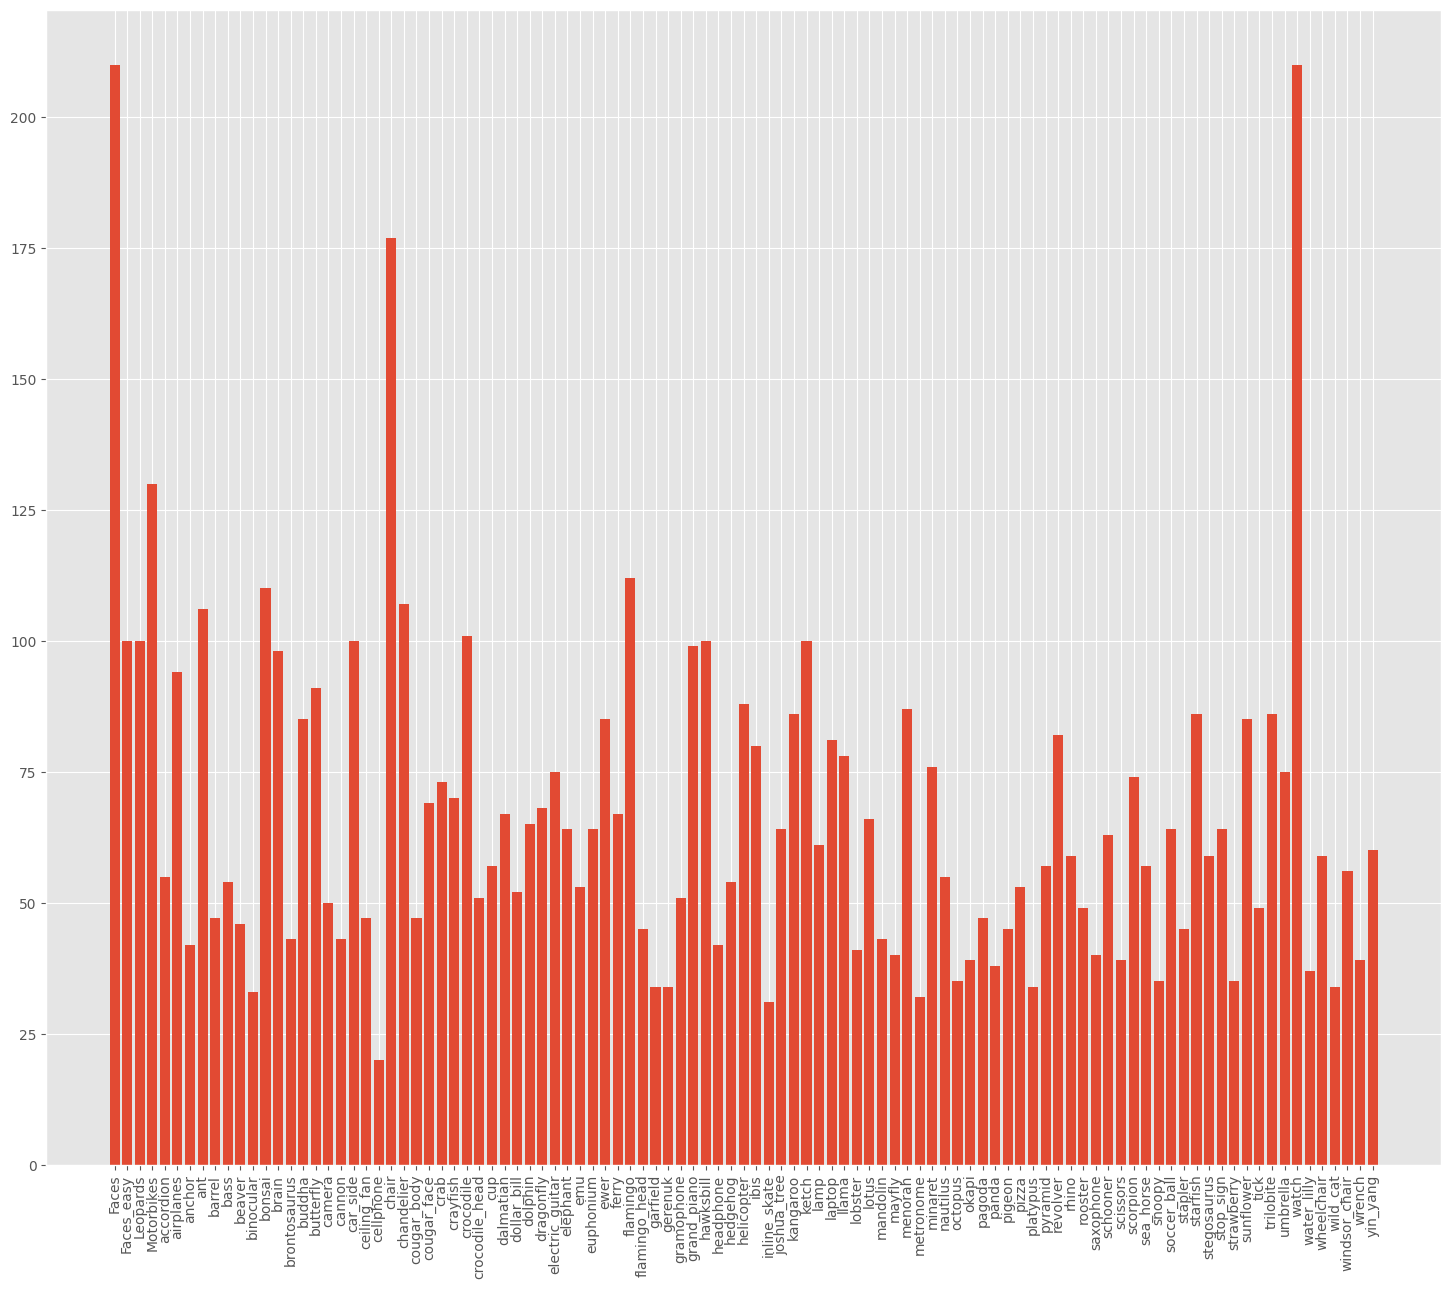

In [41]:
plt.figure(figsize=(18, 15))
plt.bar(label_arr, count_arr,)
plt.xticks(rotation='vertical')
plt.show()

In [42]:
(X, x_val , Y, y_val) = train_test_split(data, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=42)

print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (3846,)
x_test examples: (1282,)
x_val examples: (1282,)


In [43]:
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
    #  transforms.RandomRotation((-30, 30)),
    #  transforms.RandomHorizontalFlip(p=0.5),
    #  transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [44]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
 
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
valloader = DataLoader(val_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


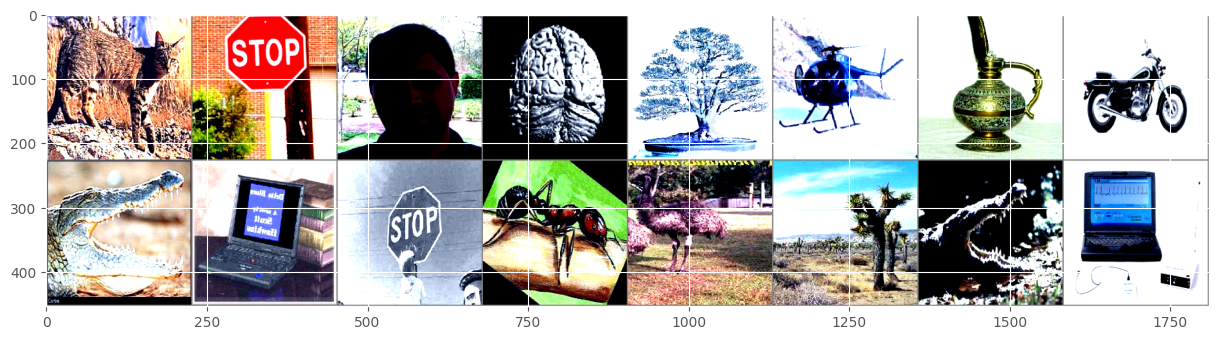

In [45]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [46]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)
        
        self.l0 = nn.Linear(512, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)

    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0

model = ResNet34(pretrained=True).to(device)
print(model)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss function
criterion = nn.CrossEntropyLoss()

c:\users\ye8i\appdata\local\programs\python\python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\ye8i\appdata\local\programs\python\python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Ye8i/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:10<00:00, 8.34MB/s]


ResNet34(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [47]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples")

#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

# training function
def fit(model, dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # print(outputs)
        # print(torch.max(target, 1)[1])
        loss = criterion(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy


train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start)/60, 'minutes')

Training on 3846 examples, validating on 1282 examples
Epoch 1 of 5
Training


  0%|                                                                                          | 0/240 [00:00<?, ?it/s]c:\users\ye8i\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
241it [09:49,  2.45s/it]                                                                                               


Train Loss: 0.1421, Train Acc: 56.58
Validating


81it [01:01,  1.31it/s]                                                                                                


Val Loss: 0.0381, Val Acc: 90.02
Epoch 2 of 5
Training


241it [09:38,  2.40s/it]                                                                                               


Train Loss: 0.0307, Train Acc: 93.55
Validating


81it [00:56,  1.43it/s]                                                                                                


Val Loss: 0.0192, Val Acc: 92.28
Epoch 3 of 5
Training


241it [09:17,  2.31s/it]                                                                                               


Train Loss: 0.0092, Train Acc: 98.78
Validating


81it [01:05,  1.24it/s]                                                                                                


Val Loss: 0.0154, Val Acc: 94.15
Epoch 4 of 5
Training


241it [09:02,  2.25s/it]                                                                                               


Train Loss: 0.0048, Train Acc: 99.43
Validating


81it [00:58,  1.38it/s]                                                                                                


Val Loss: 0.0143, Val Acc: 94.62
Epoch 5 of 5
Training


241it [08:54,  2.22s/it]                                                                                               


Train Loss: 0.0027, Train Acc: 99.66
Validating


81it [00:55,  1.45it/s]                                                                                                

Val Loss: 0.0135, Val Acc: 94.85
51.6896533370018 minutes


In [48]:
torch.save(model.state_dict(), f"resnet34_epochs{epochs}.pth")

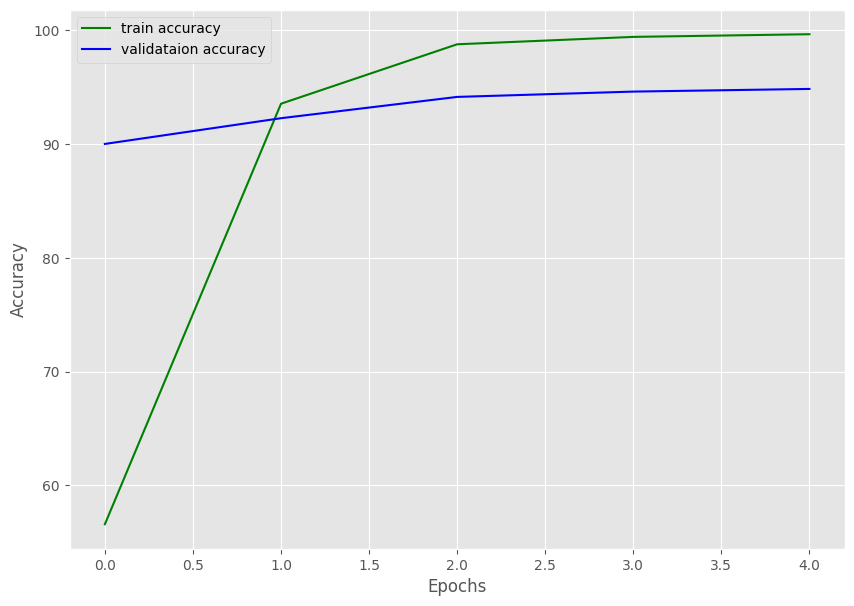

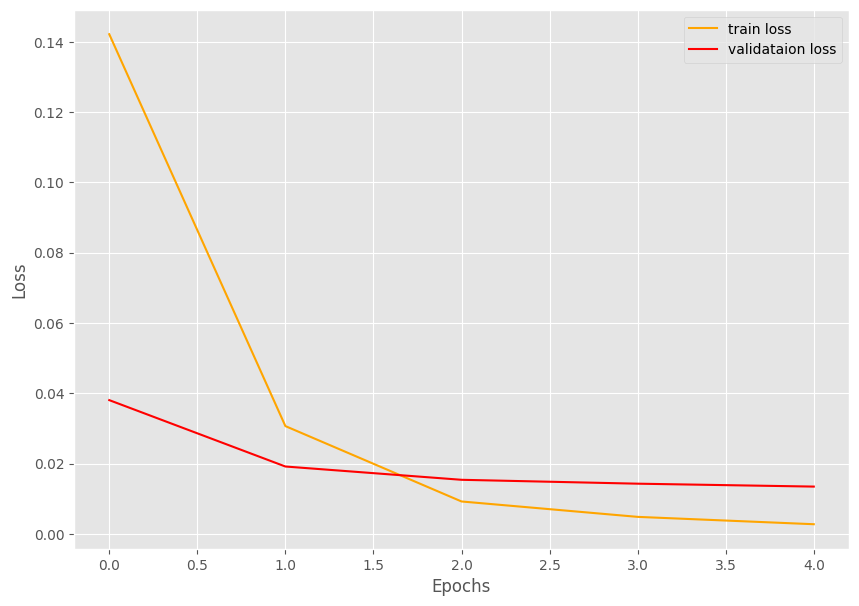

In [49]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [50]:
print(train_accuracy)
print(train_loss)
print(val_accuracy)
print(val_loss)

import joblib
joblib.dump(train_accuracy, 'train_accuracy.pkl')
joblib.dump(train_loss, 'train_loss.pkl')
joblib.dump(val_accuracy, 'val_accuracy.pkl')
joblib.dump(val_loss, 'val_loss.pkl')

[56.57826313052522, 93.55174206968279, 98.77795111804473, 99.42797711908476, 99.66198647945917]
[0.1421480885378966, 0.030662768123767305, 0.009219681285709158, 0.004838682978704099, 0.0027472427910560904]
[90.01560062402496, 92.2776911076443, 94.14976599063962, 94.61778471138845, 94.85179407176287]
[0.03805264786420486, 0.019165517521118412, 0.015385825213846894, 0.014280062204614781, 0.01345385738078929]


['val_loss.pkl']

In [51]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, target = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == torch.max(target, 1)[1]).sum().item()

print('Accuracy of the network on test images: %0.3f %%' % (
    100 * correct / total))

Accuracy of the network on test images: 94.696 %
